# Drawing samples with Markov Chain Monte Carlo methods

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Markov Chain Monte Carlo -- Metropolis Hastings

Markov Chain: Random samples from a predefined probability distribution in an ordered chain

Metropolis-Hastings algorithm

* Choose a "proposal density" $Q(y|x)$ to draw a new sample $y$ given a previous sample $x$.
* If $P(y) \geq P(x)$, keep the new sample
* If $P(y) < P(x)$, keep the new sample with probability $(P(y)/P(x))(Q(x|y)/Q(y|x))$
* If a sample is rejected, the old sample is repeated
* The normalization of $P$ doesn't matter. In the context of Bayes' theorem, this is the evidence

In [9]:
#Propose a new step (using a symmetric Gaussian proposal density centered at the old sample)
def ProposedStep(oldsamp,sigmaprop,D):
    newsamp = oldsamp + np.random.normal(0.,sigmaprop,D)
    return newsamp

#Hastings ratio
def HastingsRatio(newsamp,oldsamp,priorrange,PDF,*Pargs):
    if not ((np.array([p1 - p2 for p1, p2 in zip(newsamp, np.transpose(priorrange)[:][0])])>0).all() \
            and (np.array([p2 - p1 for p1, p2 in zip(newsamp,np.transpose(priorrange)[:][1])])>0).all()):
        acc = False
        return acc, oldsamp # make sure the samples are in the desired range
    newprob = PDF(newsamp,*Pargs)
    oldprob = PDF(oldsamp,*Pargs)
    if newprob >= oldprob:
        acc = True
        return acc, newsamp
    else:
        prob = newprob/oldprob
        acc = np.random.choice([True,False],p=[prob,1.-prob])
        return acc, acc*newsamp + (1. - acc)*oldsamp 

#Function that runs the chain
def MCMC(PDF,D,Nsteps,priorrange,sigmaprop,*Pargs):
    #Draw a random starting point
    oldsamp=np.array([np.random.uniform(priorrange[d][0],priorrange[d][1]) for d in range(D)])
    
    #Count the number of accepted samples
    count = 0 
    
    #Store all samples
    samples = [oldsamp]
    
    for i in range(Nsteps):
        newsamp = ProposedStep(oldsamp,sigmaprop,D) #Propose a new sample
        acc, newsamp = HastingsRatio(newsamp,oldsamp,priorrange,PDF,*Pargs) #decide whether or not to accept it
        samples.append(newsamp) #Add the sample to the list of samples
        if acc:
            count += 1
        oldsamp = newsamp #Move to the new sample
        
    #compute the acceptance ratio    
    AR = 1.*count/Nsteps 
    return np.array(samples), AR


Suppose we measure a sin wave with an amplitude and a frequency, so that we have data

$d = x\ cos(y t+z) + n$,

where $n$ is some observational error. 

We will assume that we have several measurements and that the errors are Gaussian and independent.

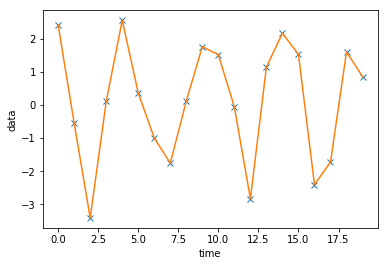

In [44]:
#Simulate a set of Nobs observations:
Nobs = 20
sigma = 1 #the standard deviation of the Gaussian noise
A = 2. #fix the true values of the two parameters
f = 4.*2.*np.pi/Nobs
phi = 1.
#Draw noise realizations:
np.random.seed(10)
n = np.random.normal(0.,sigma,Nobs)

#Observation times
t = np.arange(Nobs)

#Generate a data set:
#With and without noise
data = A*np.cos(f*t+phi) + n

plt.plot(data,'x')
plt.plot(data)
plt.xlabel('time')
plt.ylabel('data')
plt.show()

Define the posterior

In [45]:
def posterior(samp,d,t):
    x = samp[0]
    y = samp[1]
    z = samp[2]
    
    res = (d-x*np.cos(y*t+z))**2 
    #Let's assume uniform priors for all parameters
    return np.exp(-0.5*(res.sum()/sigma**2))

Draw samples from the posterior

In [46]:
np.random.seed(10)
#np.random.seed(None)
Nsteps = 200000
sigmaprop = 0.09
D=3
priorrange=np.array([[0,5],[0,np.pi],[0,np.pi]])
samples, AR = MCMC(posterior,D,Nsteps,priorrange,sigmaprop,data,t)
print 'acceptance ratio:', AR

acceptance ratio: 0.165065


Plot the chain for each parameter

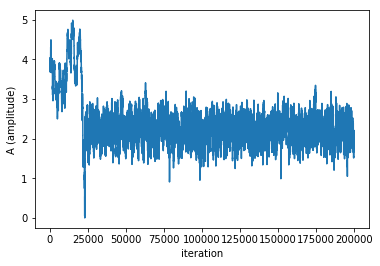

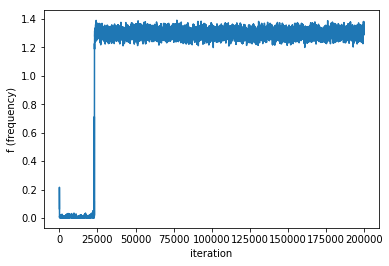

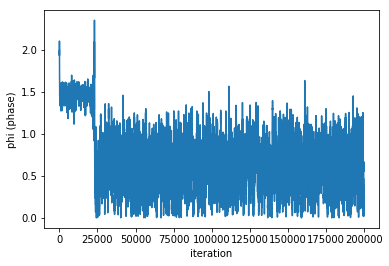

In [47]:
plt.plot(samples[:,0])
plt.xlabel('iteration')
plt.ylabel('A (amplitude)')
plt.show()

plt.plot(samples[:,1])
plt.xlabel('iteration')
plt.ylabel('f (frequency)')
plt.show()

plt.plot(samples[:,2])
plt.xlabel('iteration')
plt.ylabel('phi (phase)')
plt.show()

Use the above plots to determine how many samples to throw out as "burn-in" (i.e. before the chain settles)

In [48]:
burnin = 25000
samples = samples[burnin:]

Plot the samples for different parameters. This will reveal possible degeneracies and correlations between the parameters

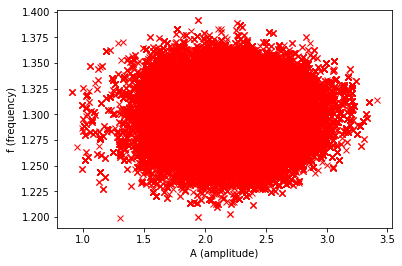

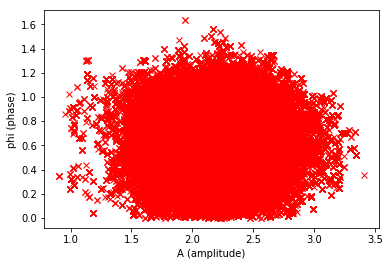

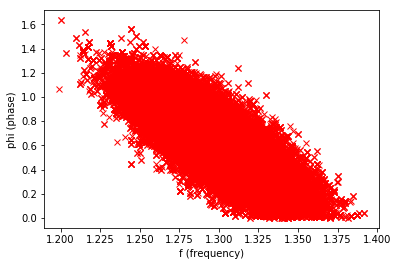

In [49]:
plt.plot(samples[:,0],samples[:,1],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('f (frequency)')
plt.show()

plt.plot(samples[:,0],samples[:,2],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('phi (phase)')
plt.show()

plt.plot(samples[:,1],samples[:,2],'x',color='red')
plt.xlabel('f (frequency)')
plt.ylabel('phi (phase)')
plt.show()


But not all samples are independent. Calculate the auto-correlation of the remaining samples

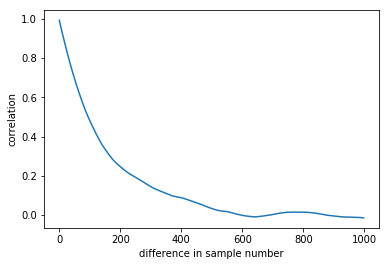

In [50]:
xmean=(np.mean(samples[:,0]))
xvar=(np.var(samples[:,0]))
ACL=np.array([(((samples[h:,0]-xmean)*(samples[:-h,0]-xmean)).sum())/(len(samples[:,0])-h)/xvar for h in range(1,1000)])                              

plt.plot(ACL)
plt.xlabel(r'difference in sample number')
plt.ylabel(r'correlation')
plt.show()

Use the plot to determine the correlation length between samples and 'thin' the chains

In [51]:
corrlength = 400
independentsamples = samples[::corrlength]
print independentsamples.shape
print 'effective acceptance ratio:', 1.*independentsamples.shape[0]/Nsteps

(438, 3)
effective acceptance ratio: 0.00219


Plot the samples for different parameters again

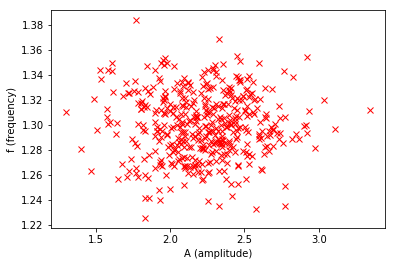

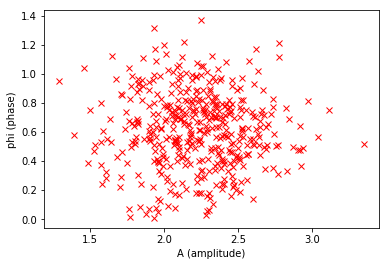

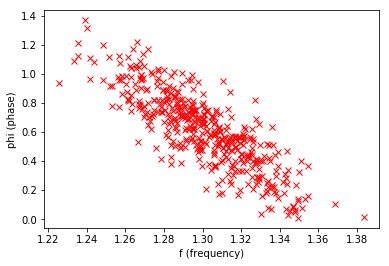

In [52]:
plt.plot(independentsamples[:,0],independentsamples[:,1],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('f (frequency)')
plt.show()

plt.plot(independentsamples[:,0],independentsamples[:,2],'x',color='red')
plt.xlabel('A (amplitude)')
plt.ylabel('phi (phase)')
plt.show()

plt.plot(independentsamples[:,1],independentsamples[:,2],'x',color='red')
plt.xlabel('f (frequency)')
plt.ylabel('phi (phase)')
plt.show()


The one dimensional posterior for each parameter is obtain by marginalizing over all other parameters. In practise, it is the normalized histogram of the samples

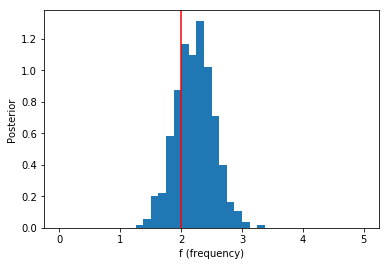

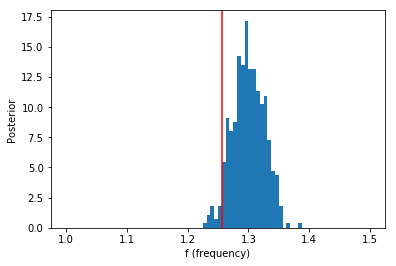

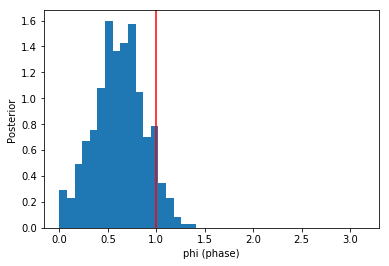

In [54]:
x_values = independentsamples[:,0]

plt.hist(x_values,range=(0,5),bins=40,normed=True)
plt.axvline(A,color='r')
plt.xlabel('f (frequency)')
plt.ylabel('Posterior')
plt.show()

y_values = independentsamples[:,1]

plt.hist(y_values,range=(1,1.5),bins=80,normed=True)
plt.axvline(f,color='r')
plt.xlabel('f (frequency)')
plt.ylabel('Posterior')
plt.show()

z_values = independentsamples[:,2]

plt.hist(z_values,range=(0,np.pi),bins=40,normed=True)
plt.axvline(phi,color='r')
plt.xlabel('phi (phase)')
plt.ylabel('Posterior')
plt.show()

The posterior distribution falls close to the 'true' value of each parameter but doesn't peak exactly at it. Try removing the noise realization from the data and rerunning the chain.

In practice: Run several chains with different starting values and make sure that they all converge to the same area.

Various python modules exist that have some of these methods pre-implemented, e.g.:
    - emcee (http://dan.iel.fm/emcee/current/)
    